**Data preprocessing**



In [1]:
# import library
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn as sk
import time
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np

In [2]:
# read the dataset
df = pd.read_csv("./Galaxy2.csv")

# first five rows of the dataset
df.head()

,specObjID,dered_u,dered_g,dered_r,dered_i,dered_z,photoRa,photoDec,redshift,zErr,class,subClass,zWarning
0,299489676975171584,16.91713,15.31460,14.55245,14.14041,13.83297,146.714203,-1.041275,0.021275,0.000009,GALAXY,NaN,0
1,299489677444933632,16.91713,15.31460,14.55245,14.14041,13.83297,146.714203,-1.041275,0.021222,0.000009,GALAXY,STARFORMING,0
2,299489951853078528,20.18201,18.45391,17.33205,16.89840,16.59294,146.919454,-0.990523,0.213925,0.000052,GALAXY,NaN,0
3,299489952322840576,20.97757,18.85416,17.52073,17.00673,16.65681,146.744138,-0.652218,0.203783,0.000039,GALAXY,NaN,0
4,299490501608892416,20.53679,18.46119,17.18082,16.61607,16.14976,146.859831,-0.808898,0.126554,0.000062,GALAXY,NaN,0


In [3]:
# dataset columns list
df.columns

Index(['specObjID', 'dered_u', 'dered_g', 'dered_r', 'dered_i', 'dered_z',
       'photoRa', 'photoDec', 'redshift', 'zErr', 'class', 'subClass',
       'zWarning'],
      dtype='object')

In [4]:
# the dataset shape
df.shape

(300000, 13)

In [5]:
# statistic parameters of the dataset
df.describe()

,specObjID,dered_u,dered_g,dered_r,dered_i,dered_z,photoRa,photoDec,redshift,zErr,zWarning
count,3.000000e+05,300000.000000,300000.000000,300000.000000,300000.000000,300000.000000,300000.000000,300000.000000,300000.000000,300000.000000,300000.000000
mean,6.177624e+17,19.217736,17.535551,17.368724,16.773317,16.220951,168.732344,16.693637,0.154498,0.011971,0.325003
std,1.947129e+17,89.625110,87.717963,1.119572,40.903769,65.938708,98.780428,24.822603,0.175946,1.483621,5.784746
min,2.994897e+17,-9999.000000,-9999.000000,11.196000,-9999.000000,-9999.000000,0.001718,-11.252825,-0.010885,-6.000000,0.000000
25%,4.560526e+17,19.017860,17.573330,16.807657,16.407460,16.110557,118.139675,-0.321807,0.075340,0.000012,0.000000
50%,6.115051e+17,19.755120,18.163080,17.347860,16.937725,16.645995,173.849524,2.117596,0.117110,0.000022,0.000000
75%,7.826289e+17,20.598780,18.761800,17.735413,17.343792,17.114332,228.357241,42.049454,0.182627,0.000037,0.000000
max,1.026891e+18,30.221980,30.952920,31.521720,30.854610,28.571020,359.997379,68.743547,7.003870,600.803100,198.000000


In [6]:
# check the class column
df['class'].unique()

array(['GALAXY', 'STAR', 'QSO'], dtype=object)

In [7]:
# data preprocessing
df = df[(df['zWarning']==0)&(df['class']!='STAR')]  # select data when zWarning = 0 and class != STAR
df = df[df['dered_g'] != df['dered_g'].min()]
df = df[df['dered_u'] != df['dered_u'].min()]
df = df[df['dered_i'] != df['dered_i'].min()]
df = df[df['dered_z'] != df['dered_z'].min()]

In [8]:
# the dataset after data preprocessing
df.head()

,specObjID,dered_u,dered_g,dered_r,dered_i,dered_z,photoRa,photoDec,redshift,zErr,class,subClass,zWarning
0,299489676975171584,16.91713,15.31460,14.55245,14.14041,13.83297,146.714203,-1.041275,0.021275,0.000009,GALAXY,NaN,0
1,299489677444933632,16.91713,15.31460,14.55245,14.14041,13.83297,146.714203,-1.041275,0.021222,0.000009,GALAXY,STARFORMING,0
2,299489951853078528,20.18201,18.45391,17.33205,16.89840,16.59294,146.919454,-0.990523,0.213925,0.000052,GALAXY,NaN,0
3,299489952322840576,20.97757,18.85416,17.52073,17.00673,16.65681,146.744138,-0.652218,0.203783,0.000039,GALAXY,NaN,0
4,299490501608892416,20.53679,18.46119,17.18082,16.61607,16.14976,146.859831,-0.808898,0.126554,0.000062,GALAXY,NaN,0


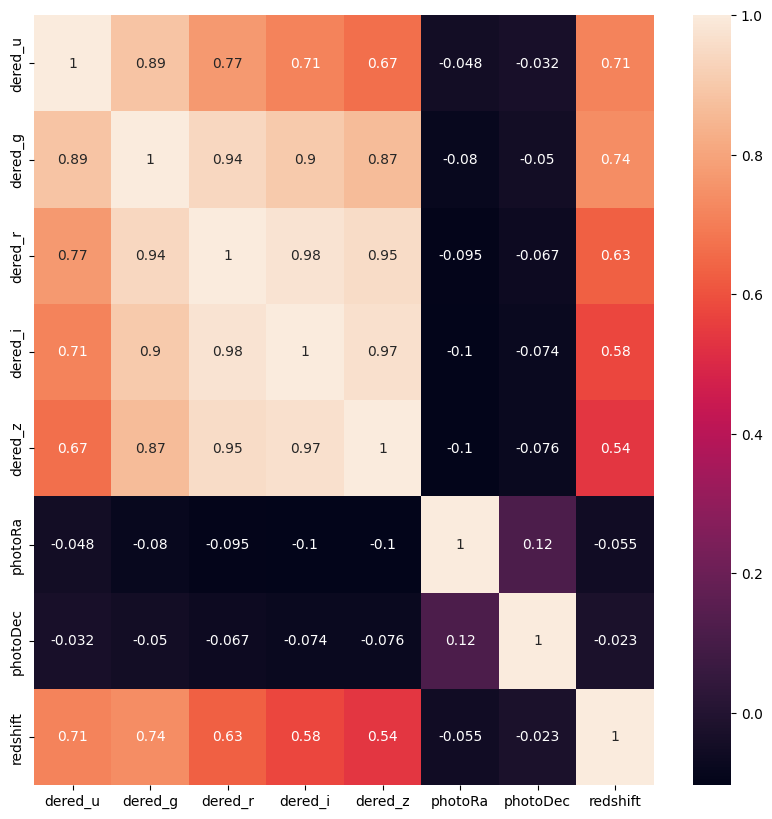

In [9]:
# plot correlation matrix between columns
plt.figure(figsize=(10,10))
sns.heatmap(df[['dered_u','dered_g','dered_r','dered_i','dered_z','photoRa','photoDec','redshift']].corr(), annot=True)
plt.show()

In [10]:
# shape of the cleaned dataset
df.shape

(292337, 13)

In [11]:
# create difference of each band
list_phot = ['u','g','r','i','z']

for i in range(len(list_phot)-1):
    try:
      df[f'{list_phot[i]}-{list_phot[i+1]}'] = df[f'dered_{list_phot[i]}'] - df[f'dered_{list_phot[i+1]}']
    except:
        pass

In [14]:
# create the dummy dataset
df_testing = df.copy()
df_testing['class'] = df_testing['class'].map({'GALAXY':0,'QSO':1})
df_testing = pd.get_dummies(df_testing, dtype=int)

In [15]:
# create the columns of the dummy dataset
df_testing.columns

Index(['specObjID', 'dered_u', 'dered_g', 'dered_r', 'dered_i', 'dered_z',
       'photoRa', 'photoDec', 'redshift', 'zErr', 'class', 'zWarning', 'u-g',
       'g-r', 'r-i', 'i-z', 'subClass_AGN', 'subClass_AGN BROADLINE',
       'subClass_BROADLINE', 'subClass_STARBURST',
       'subClass_STARBURST BROADLINE', 'subClass_STARFORMING',
       'subClass_STARFORMING BROADLINE'],
      dtype='object')

In [17]:
# create the ML testing dataset
df_testing_ml = df_testing[['redshift', 'class', 'u-g', 'g-r', 'r-i', 'i-z']]

In [18]:
# the ML testing dataset
df_testing_ml.head()

,redshift,class,u-g,g-r,r-i,i-z
0,0.021275,0,1.60253,0.76215,0.41204,0.30744
1,0.021222,0,1.60253,0.76215,0.41204,0.30744
2,0.213925,0,1.72810,1.12186,0.43365,0.30546
3,0.203783,0,2.12341,1.33343,0.51400,0.34992
4,0.126554,0,2.07560,1.28037,0.56475,0.46631


In [19]:
# statistic parameters of the ML testing dataset
df_testing_ml.describe()

,redshift,class,u-g,g-r,r-i,i-z
count,292337.000000,292337.000000,292337.00000,292337.000000,292337.00000,292337.000000
mean,0.151118,0.019228,1.71382,0.929789,0.42564,0.288749
std,0.122889,0.137325,0.77579,0.455454,0.23317,0.265250
min,-0.010373,0.000000,-14.55492,-12.280610,-12.14336,-11.056910
25%,0.076843,0.000000,1.27340,0.657720,0.36303,0.238790
50%,0.117992,0.000000,1.70201,0.880890,0.41646,0.311080
75%,0.182293,0.000000,1.95837,1.097760,0.47517,0.353270
max,6.980912,1.000000,13.43636,11.823710,11.96671,16.134540


In [20]:
# drop duplicated data of the ML testing dataset
df_testing_ml.drop_duplicates(inplace=True, ignore_index=True)

<ipython-input-20-532915487>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_testing_ml.drop_duplicates(inplace=True, ignore_index=True)


In [21]:
# the ML testing dataset after drop duplicates
df_testing_ml.head()

,redshift,class,u-g,g-r,r-i,i-z
0,0.021275,0,1.60253,0.76215,0.41204,0.30744
1,0.021222,0,1.60253,0.76215,0.41204,0.30744
2,0.213925,0,1.72810,1.12186,0.43365,0.30546
3,0.203783,0,2.12341,1.33343,0.51400,0.34992
4,0.126554,0,2.07560,1.28037,0.56475,0.46631
...,...,...,...,...,...,...
292283,0.050493,0,1.83602,0.78007,0.37262,0.27744
292284,0.041180,0,1.00718,0.39572,0.21909,0.07942
292285,0.410612,0,5.40254,1.80023,0.63905,0.42803
292286,0.184791,1,0.53357,0.78650,0.39518,0.17526


In [22]:
# remove outlier of the ML testing dataset
cols = ['u-g', 'g-r', 'r-i', 'i-z']

df_clean = df_testing_ml.copy()

for col in cols:
    Q1 = df_clean[col].quantile(0.25)
    Q3 = df_clean[col].quantile(0.75)
    IQR = Q3 - Q1

    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # filter the dataframe with condition in IQR range
    df_clean = df_clean[(df_clean[col] >= lower_bound) & (df_clean[col] <= upper_bound)]

print(f"Data awal: {len(df_testing_ml)} baris")
print(f"Data setelah hapus outlier IQR: {len(df_clean)} baris")

Data awal: 292288 baris
Data setelah hapus outlier IQR: 237269 baris


In [23]:
# statistic of the cleaned dataset
df_clean.describe()

,redshift,class,u-g,g-r,r-i,i-z
count,237269.000000,237269.000000,237269.000000,237269.000000,237269.000000,237269.000000
mean,0.123308,0.014321,1.639614,0.867249,0.409586,0.291680
std,0.075473,0.118812,0.410520,0.268248,0.072297,0.075453
min,-0.010229,0.000000,0.246700,0.037330,0.209430,0.080420
25%,0.076011,0.000000,1.322530,0.682960,0.368620,0.247660
50%,0.110710,0.000000,1.705540,0.865400,0.411920,0.307790
75%,0.152725,0.000000,1.926780,1.021210,0.454220,0.344650
max,6.464488,1.000000,2.985540,1.675320,0.601110,0.501550


**ML model development**

In [24]:
# split feature and target data
x = df_clean.drop(columns='redshift')
y = df_clean['redshift']

#
scaler = sk.preprocessing.StandardScaler()
x_scaled = scaler.fit_transform(x)

# binning data to five parts
y_binned = pd.qcut(y, q=5, labels=False, duplicates='drop')

In [25]:
# count each the binned data
counts = pd.Series(y_binned).value_counts().sort_index()
print(counts)

redshift
0    47454
1    47454
2    47454
3    47453
4    47454
Name: count, dtype: int64


In [26]:
# split data train and test
x_train, x_test, y_train, y_test = sk.model_selection.train_test_split(x, y, test_size = 0.25, random_state = 0, stratify = y_binned)

In [27]:
# convert train and test data into numpy array
x_train = x_train.to_numpy()
x_test = x_test.to_numpy()
y_train = y_train.to_numpy()
y_test = y_test.to_numpy()

In [30]:
# dataset class
class RegressionDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)
    def __len__(self):
        return len(self.X)
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# train and test dataset
train_dataset = RegressionDataset(x_train, y_train)
test_dataset = RegressionDataset(x_test, y_test)

# train and test data loader
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

1. CNN, Random Forest and Extra Trees Model

In [28]:
# define the CNN model
class CNN1DRegressor(nn.Module):
    def __init__(self, input_features, output_channels=32, kernel_size=3):
        super(CNN1DRegressor, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=1, out_channels=output_channels, kernel_size=kernel_size, padding='same')
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool1d(kernel_size=2)
        pooled_output_size = input_features // 2
        self.fc1 = nn.Linear(output_channels * pooled_output_size, 64)
        self.relu2 = nn.ReLU()
        self.fc2 = nn.Linear(64, 1)

    def forward(self, x):
        x = x.unsqueeze(1)
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.pool1(x)
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        x = self.relu2(x)
        x = self.fc2(x)
        return x.squeeze(1)

In [31]:
# train the CNN model
input_features = x_train.shape[1]
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
cnn_model = CNN1DRegressor(input_features=input_features).to(device)

criterion = nn.MSELoss()
optimizer = optim.Adam(cnn_model.parameters(), lr=1e-4) # using Adam optimizer

start_time = time.time()

n_epochs = 100  # using 100 epoch
for epoch in range(n_epochs):
    cnn_model.train()
    train_losses = []
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        preds = cnn_model(X_batch)
        loss = criterion(preds, y_batch)
        loss.backward()
        optimizer.step()
        train_losses.append(loss.item())

    cnn_model.eval()
    val_losses = []
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            preds = cnn_model(X_batch)
            loss = criterion(preds, y_batch)
            val_losses.append(loss.item())

    print(f"Epoch {epoch+1}/{n_epochs} - Train Loss: {np.mean(train_losses):.4f} - Val Loss: {np.mean(val_losses):.4f}")

cnn_model.eval()
cnn_preds = []
targets_cnn = []
with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch = X_batch.to(device)
        pred = cnn_model(X_batch).cpu().numpy()
        cnn_preds.append(pred)
        targets_cnn.append(y_batch.numpy())

cnn_preds = np.concatenate(cnn_preds)
targets_cnn = np.concatenate(targets_cnn)
end_time = time.time()

print(f'\nCNN Model Metrics:')
print(f'R2 = {sk.metrics.r2_score(targets_cnn, cnn_preds):.4f}, MAE = {sk.metrics.mean_absolute_error(targets_cnn, cnn_preds):.4f}, RMSE = {sk.metrics.mean_squared_error(targets_cnn, cnn_preds):.4f}, Time = {(end_time-start_time):.1f}')

Epoch 1/100 - Train Loss: 0.0024 - Val Loss: 0.0016
Epoch 2/100 - Train Loss: 0.0020 - Val Loss: 0.0016
Epoch 3/100 - Train Loss: 0.0019 - Val Loss: 0.0015
Epoch 4/100 - Train Loss: 0.0019 - Val Loss: 0.0015
Epoch 5/100 - Train Loss: 0.0019 - Val Loss: 0.0015
Epoch 6/100 - Train Loss: 0.0019 - Val Loss: 0.0015
Epoch 7/100 - Train Loss: 0.0019 - Val Loss: 0.0016
Epoch 8/100 - Train Loss: 0.0018 - Val Loss: 0.0015
Epoch 9/100 - Train Loss: 0.0018 - Val Loss: 0.0015
Epoch 10/100 - Train Loss: 0.0018 - Val Loss: 0.0015
Epoch 11/100 - Train Loss: 0.0018 - Val Loss: 0.0015
Epoch 12/100 - Train Loss: 0.0018 - Val Loss: 0.0015
Epoch 13/100 - Train Loss: 0.0018 - Val Loss: 0.0015
Epoch 14/100 - Train Loss: 0.0018 - Val Loss: 0.0015
Epoch 15/100 - Train Loss: 0.0018 - Val Loss: 0.0015
Epoch 16/100 - Train Loss: 0.0018 - Val Loss: 0.0015
Epoch 17/100 - Train Loss: 0.0018 - Val Loss: 0.0014
Epoch 18/100 - Train Loss: 0.0018 - Val Loss: 0.0015
Epoch 19/100 - Train Loss: 0.0018 - Val Loss: 0.0014
Ep

In [32]:
# define the Random Forest (RF) and Extra Trees (ET) regressor model
rf = sk.ensemble.RandomForestRegressor(random_state=42)
et = sk.ensemble.ExtraTreesRegressor(random_state=42)

# fitting the data over the model
rf.fit(x_train, y_train)
et.fit(x_train, y_train)

ExtraTreesRegressor(random_state=42)

In [33]:
# predict the data using RF and ET model
start_time_rf = time.time()
rf_val_pred = rf.predict(x_test)
end_time_rf = time.time()
print(f"RF prediction time:{end_time_rf-start_time_rf}")

start_time_et = time.time()
et_val_pred = et.predict(x_test)
end_time_et = time.time()
print(f"ET prediction time:{end_time_et-start_time_et}")

RF prediction time:3.709214925765991
ET prediction time:4.159949541091919


In [34]:
# Calculate R-Square, MASE, MAE of each model
r2_rf = sk.metrics.r2_score(y_test, rf_val_pred)
mse_rf = sk.metrics.mean_squared_error(y_test, rf_val_pred)
mae_rf = sk.metrics.mean_absolute_error(y_test, rf_val_pred)

r2_et = sk.metrics.r2_score(y_test, et_val_pred)
mse_et = sk.metrics.mean_squared_error(y_test, et_val_pred)
mae_et = sk.metrics.mean_absolute_error(y_test, et_val_pred)

print(f"R² RF: {r2_rf:.4f}")
print(f"MSE RF: {mse_rf:.4f}")
print(f"MAE RF: {mae_rf:.4f}")
print(f"R² ET: {r2_et:.4f}")
print(f"MSE ET: {mse_et:.4f}")
print(f"MAE ET: {mae_et:.4f}")

R² RF: 0.7650
MSE RF: 0.0013
MAE RF: 0.0163
R² ET: 0.7900
MSE ET: 0.0011
MAE ET: 0.0146


In [35]:
# concatenate the predict data from RF, ET and CNN
start_stack_time = time.time()
cnn_model.eval()
mlp_preds = []
with torch.no_grad():
    for X_batch, _ in test_loader:
        X_batch = X_batch.to(device)
        pred = cnn_model(X_batch).cpu().numpy()
        mlp_preds.append(pred)
mlp_val_pred = np.concatenate(mlp_preds).flatten()
rf_val_pred = rf.predict(x_test)
et_val_pred = et.predict(x_test)

X_stack = np.vstack([rf_val_pred, et_val_pred, mlp_val_pred]).T

# defining and fitting data over the Linear Regression
meta_model = sk.linear_model.LinearRegression()
meta_model.fit(X_stack, y_test)

# predict data using Linear Regression model
y_pred_stack = meta_model.predict(X_stack)
end_stack_time = time.time()
print(f"Stacking prediction time:{end_stack_time-start_stack_time}")

Stacking prediction time:11.31101942062378


In [36]:
# calculate the R-Square, MAE and MSE of Linear Regression model
r2_stack = sk.metrics.r2_score(y_test, y_pred_stack)
mse = sk.metrics.mean_squared_error(y_test, y_pred_stack)
mae = sk.metrics.mean_absolute_error(y_test, y_pred_stack)
print(f"R² Stacking Ensemble: {r2_stack:.4f}")
print(f"MSE Stacking Ensemble: {mse:.4f}")
print(f"MAE Stacking Ensemble: {mae:.4f}")

R² Stacking Ensemble: 0.7984
MSE Stacking Ensemble: 0.0011
MAE Stacking Ensemble: 0.0157


2. Best Random Forest, Extra Trees and CNN model

In [ ]:
# define Extra Trees parameter
et_param_grid = {
    'n_estimators': [100, 300, 500],
    'max_depth': [10, 20, 40, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2']
}

# define the Extra Trees model
et = sk.ensemble.ExtraTreesRegressor(random_state=42)

# searching the best parameter
et_search = sk.model_selection.RandomizedSearchCV(
    estimator=et,
    param_distributions=et_param_grid,
    n_iter=30,
    cv=3,
    scoring='neg_median_absolute_error',
    verbose=1,
    random_state=42,
    n_jobs=-1
)

# fitting the data over the best Extra Trees model
et_search.fit(x_train, y_train)
best_et = et_search.best_estimator_

Fitting 3 folds for each of 30 candidates, totalling 90 fits


/usr/local/lib/python3.11/dist-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


In [ ]:
# define Random Forest parameter
rf_param_grid = {
    'n_estimators': [100, 300, 500],
    'max_depth': [10, 20, 40, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2']
}

# define the Random Forest model
rf = sk.ensemble.RandomForestRegressor(random_state=42)

# searching the best parameter
rf_search = sk.model_selection.RandomizedSearchCV(
    estimator=rf,
    param_distributions=rf_param_grid,
    n_iter=30,
    cv=3,
    scoring='neg_median_absolute_error',
    verbose=1,
    random_state=42,
    n_jobs=-1
)

# fitting the data over the best Random Forest model
rf_search.fit(x_train, y_train)
best_rf = rf_search.best_estimator_

In [ ]:
# predict data using best RF and ET model
start_time_rf = time.time()
rf_val_pred = best_rf.predict(x_test)
end_time_rf = time.time()
print(f"RF prediction time:{end_time_rf-start_time_rf}")

start_time_et = time.time()
et_val_pred = best_et.predict(x_test)
end_time_et = time.time()
print(f"ET prediction time:{end_time_et-start_time_et}")

RF prediction time:5.477965593338013
ET prediction time:6.635759353637695


In [ ]:
# calculate the R-Square, MAE and MSE of best RF and ET model
r2_rf = sk.metrics.r2_score(y_test, rf_val_pred)
mse_rf = sk.metrics.mean_squared_error(y_test, rf_val_pred)
mae_rf = sk.metrics.mean_absolute_error(y_test, rf_val_pred)

r2_et = sk.metrics.r2_score(y_test, et_val_pred)
mse_et = sk.metrics.mean_squared_error(y_test, et_val_pred)
mae_et = sk.metrics.mean_absolute_error(y_test, et_val_pred)

print(f"R² RF: {r2_rf:.4f}")
print(f"MSE RF: {mse_rf:.4f}")
print(f"MAE RF: {mae_rf:.4f}")
print(f"R² ET: {r2_et:.4f}")
print(f"MSE ET: {mse_et:.4f}")
print(f"MAE ET: {mae_et:.4f}")

R² RF: 0.7984
MSE RF: 0.0011
MAE RF: 0.0158
R² ET: 0.8052
MSE ET: 0.0011
MAE ET: 0.0142


In [ ]:
# concatenate the predict data from best RF, best ET and CNN
start_stack_time = time.time()
cnn_model.eval()
mlp_preds = []
with torch.no_grad():
    for X_batch, _ in test_loader:
        X_batch = X_batch.to(device)
        pred = cnn_model(X_batch).cpu().numpy()
        mlp_preds.append(pred)
mlp_val_pred = np.concatenate(mlp_preds).flatten()
rf_val_pred = best_rf.predict(x_test)
et_val_pred = best_et.predict(x_test)

X_stack = np.vstack([rf_val_pred, et_val_pred, mlp_val_pred]).T

# defining and fitting Linear Regression data
meta_model = sk.linear_model.LinearRegression()
meta_model.fit(X_stack, y_test)

# predict data using Linear Regression model
y_pred_stack = meta_model.predict(X_stack)
end_stack_time = time.time()
print(f"Stacking prediction time:{end_stack_time-start_stack_time}")

Stacking prediction time:13.273115396499634


In [ ]:
# calculate the R-Square, MAE and MSE of Linear Regression model
r2_stack = sk.metrics.r2_score(y_test, y_pred_stack)
mse = sk.metrics.mean_squared_error(y_test, y_pred_stack)
mae = sk.metrics.mean_absolute_error(y_test, y_pred_stack)
print(f"R² Stacking Ensemble: {r2_stack:.4f}")
print(f"MSE Stacking Ensemble: {mse:.4f}")
print(f"MAE Stacking Ensemble: {mae:.4f}")

R² Stacking Ensemble: 0.8076
MSE Stacking Ensemble: 0.0010
MAE Stacking Ensemble: 0.0149


In [ ]:
# calculate median bias, standard deviation, NMAD, oulier fraction and outlier fraction 3 sigma
delta_raw = y_pred_stack - y_test
delta_z = delta_raw / (1 + y_test)

median_bias = np.median(delta_z)
sigma = np.std(delta_z)
nmad = 1.48 * np.median(np.abs(delta_z - np.median(delta_z)))
outlier_fraction = np.mean(np.abs(delta_raw) / (1 + y_test) > 0.15)
outlier_fraction_3sigma = np.mean(np.abs(delta_z - median_bias) > 3 * sigma)

print(f"Median bias: {median_bias:.4f}")
print(f"Sigma (std): {sigma:.4f}")
print(f"NMAD: {nmad:.4f}")
print(f"Outlier fraction: {outlier_fraction:.2%}")
print(f"Outlier fraction 3 sigma: {outlier_fraction_3sigma:.2%}")

Median bias: 0.0006
Sigma (std): 0.0230
NMAD: 0.0109
Outlier fraction: 0.19%
Outlier fraction 3 sigma: 1.24%


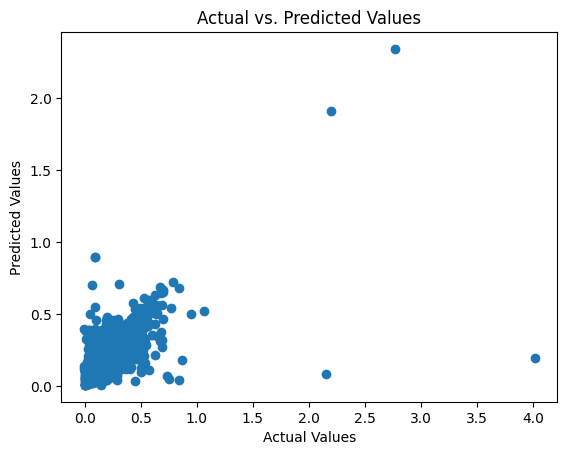

In [ ]:
# plot actual vs predicted values
plt.scatter(y_test, y_pred_stack)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs. Predicted Values')
plt.show()

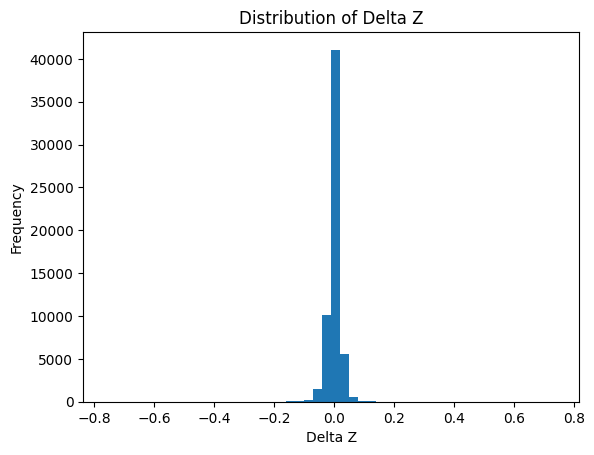

In [ ]:
# plot the distribution of delta Z
plt.hist(delta_z, bins=50)
plt.xlabel('Delta Z')
plt.ylabel('Frequency')
# plt.xlim(-0.1,0.1)
plt.title('Distribution of Delta Z')
plt.show()

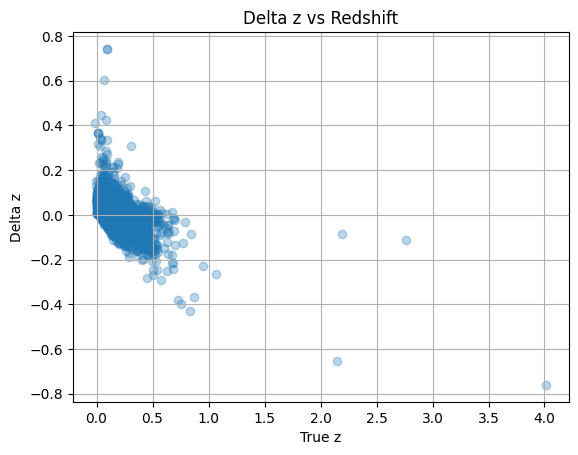

In [ ]:
# plot delta z vs redshift
plt.scatter(y_test, delta_z, alpha=0.3)
plt.xlabel('True z')
plt.ylabel('Delta z')
plt.title('Delta z vs Redshift')
plt.grid(True)
plt.show()